In [27]:
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from collections import Counter
import os
import cv2

# Paths to original dataset splits
# NEED TO CHANGE THESE PATHS TO YOUR OWN
base_path = "/Users/bilalnajar/PycharmProjects/AAI-521/dataset/New Plant Diseases Dataset(Augmented)"
train_path = os.path.join(base_path, "/Users/bilalnajar/PycharmProjects/AAI-521/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train")
val_path = os.path.join(base_path, "/Users/bilalnajar/PycharmProjects/AAI-521/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid")
test_path = os.path.join(base_path, "/Users/bilalnajar/PycharmProjects/AAI-521/dataset/test")

# Verbose control for logging
VERBOSE = False

def log(message):
    """Print log messages only if VERBOSE is enabled."""
    if VERBOSE:
        print(message)

# Exploratory Data Analysis


Performing EDA...

Train Dataset:
Total classes: 38
Sample classes: ['Strawberry___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Blueberry___healthy', 'Corn_(maize)___healthy']
Total images: 70295
Number of plant types: 14
Number of diseases: 20
Healthy samples: 22294
Diseased samples: 48001


/var/folders/bt/spx_pkps3xs3hctqcx6dj9kw0000gn/T/ipykernel_14593/268566623.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_plant_types))


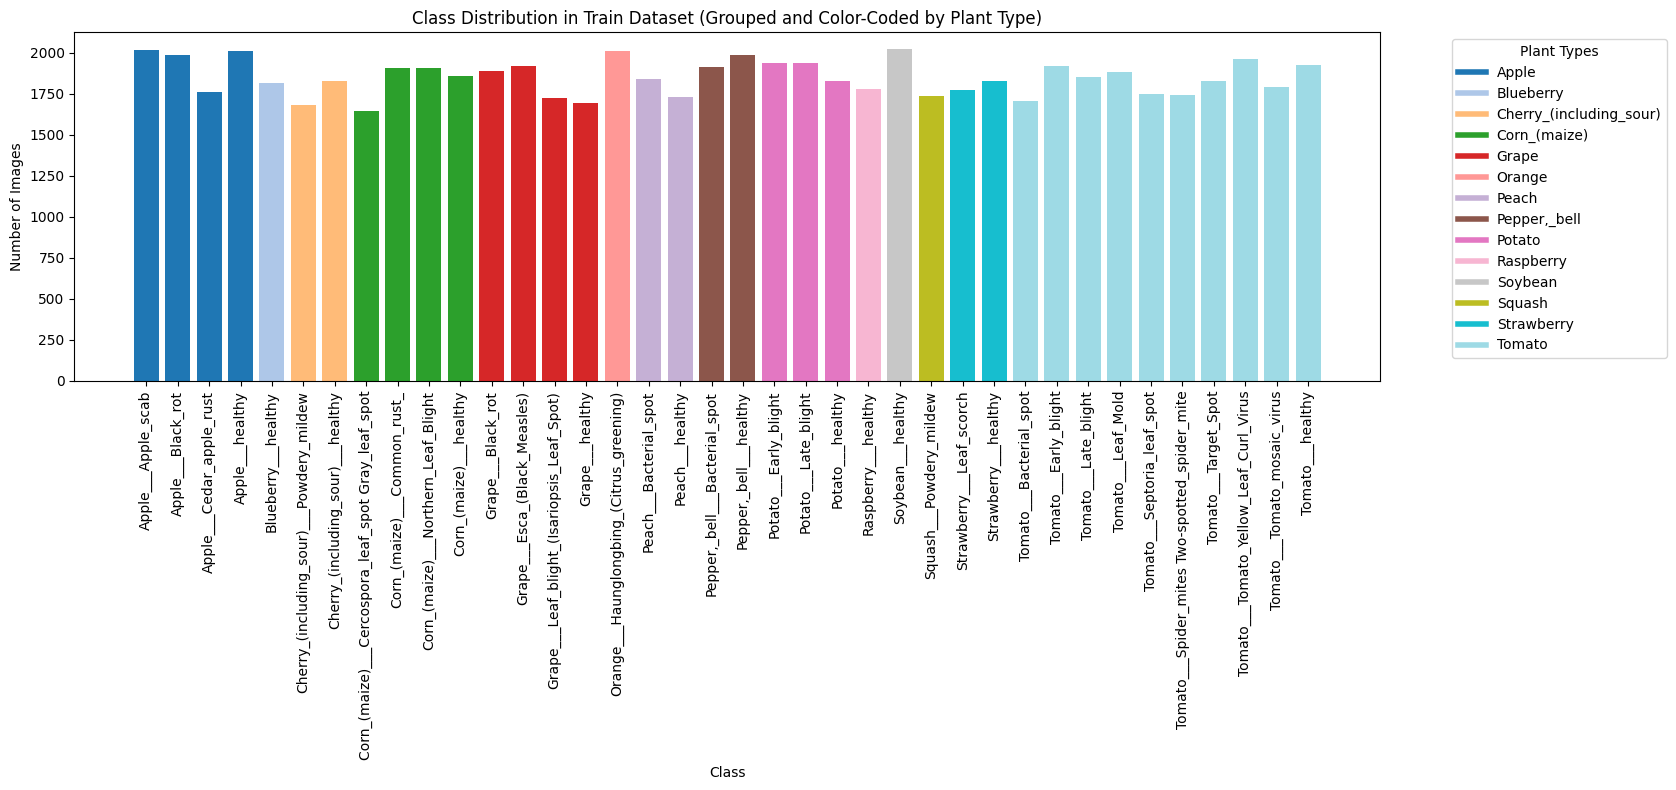

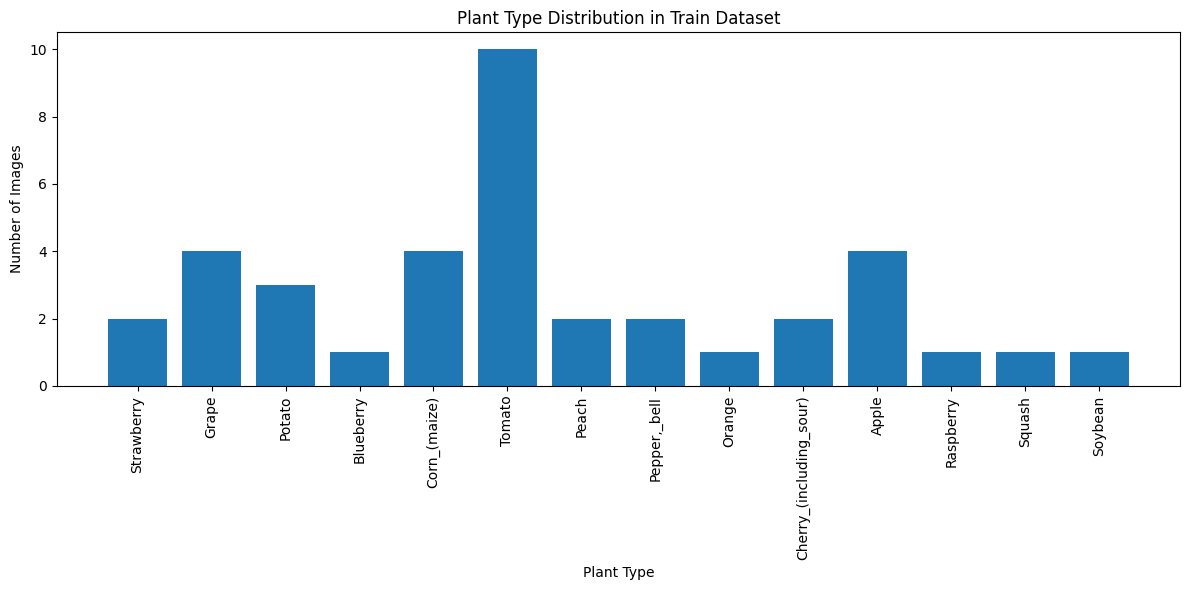

/var/folders/bt/spx_pkps3xs3hctqcx6dj9kw0000gn/T/ipykernel_14593/268566623.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Disease", bbox_to_anchor=(1.05, 1), loc='upper left')


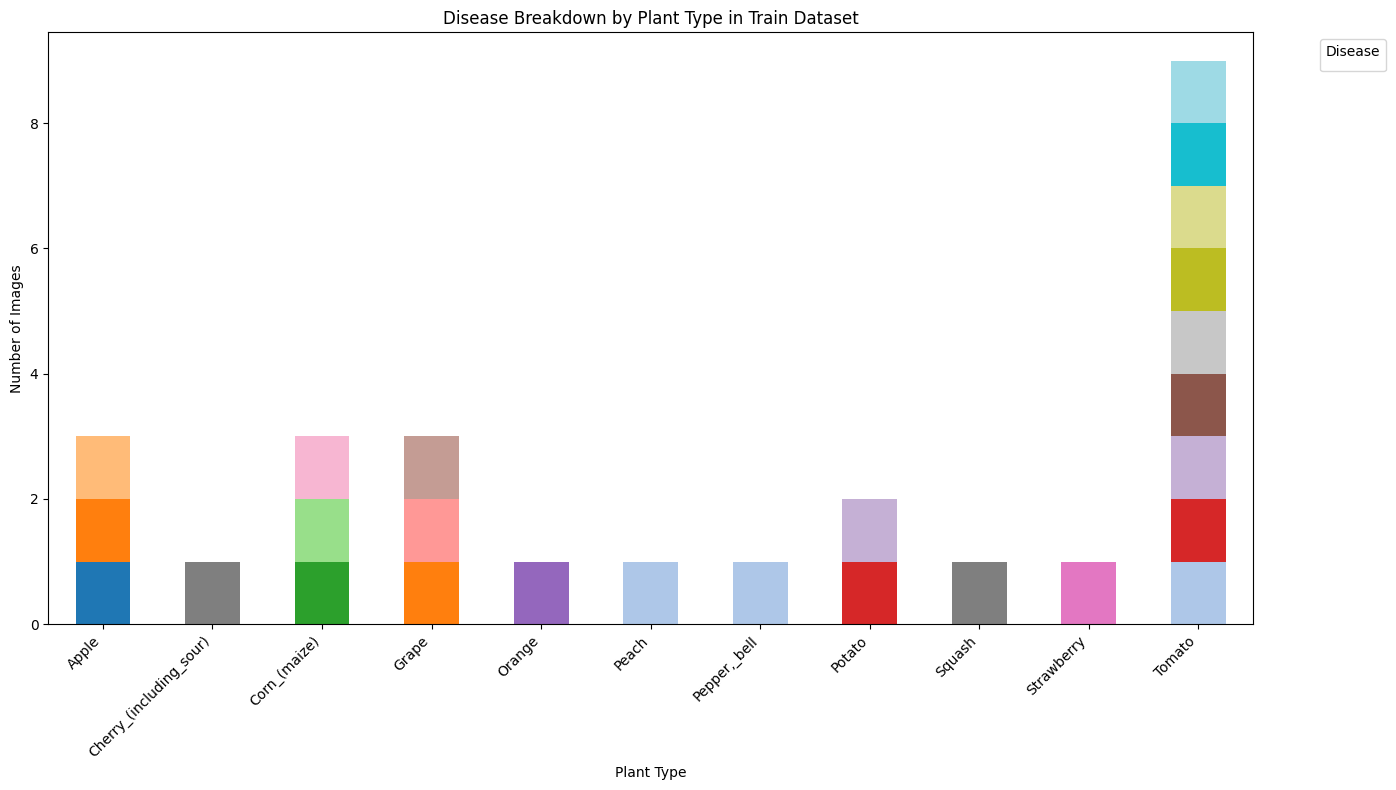

/var/folders/bt/spx_pkps3xs3hctqcx6dj9kw0000gn/T/ipykernel_14593/268566623.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_plant_types))



Validation Dataset:
Total classes: 38
Sample classes: ['Strawberry___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Blueberry___healthy', 'Corn_(maize)___healthy']
Total images: 17572
Number of plant types: 14
Number of diseases: 20
Healthy samples: 5572
Diseased samples: 12000


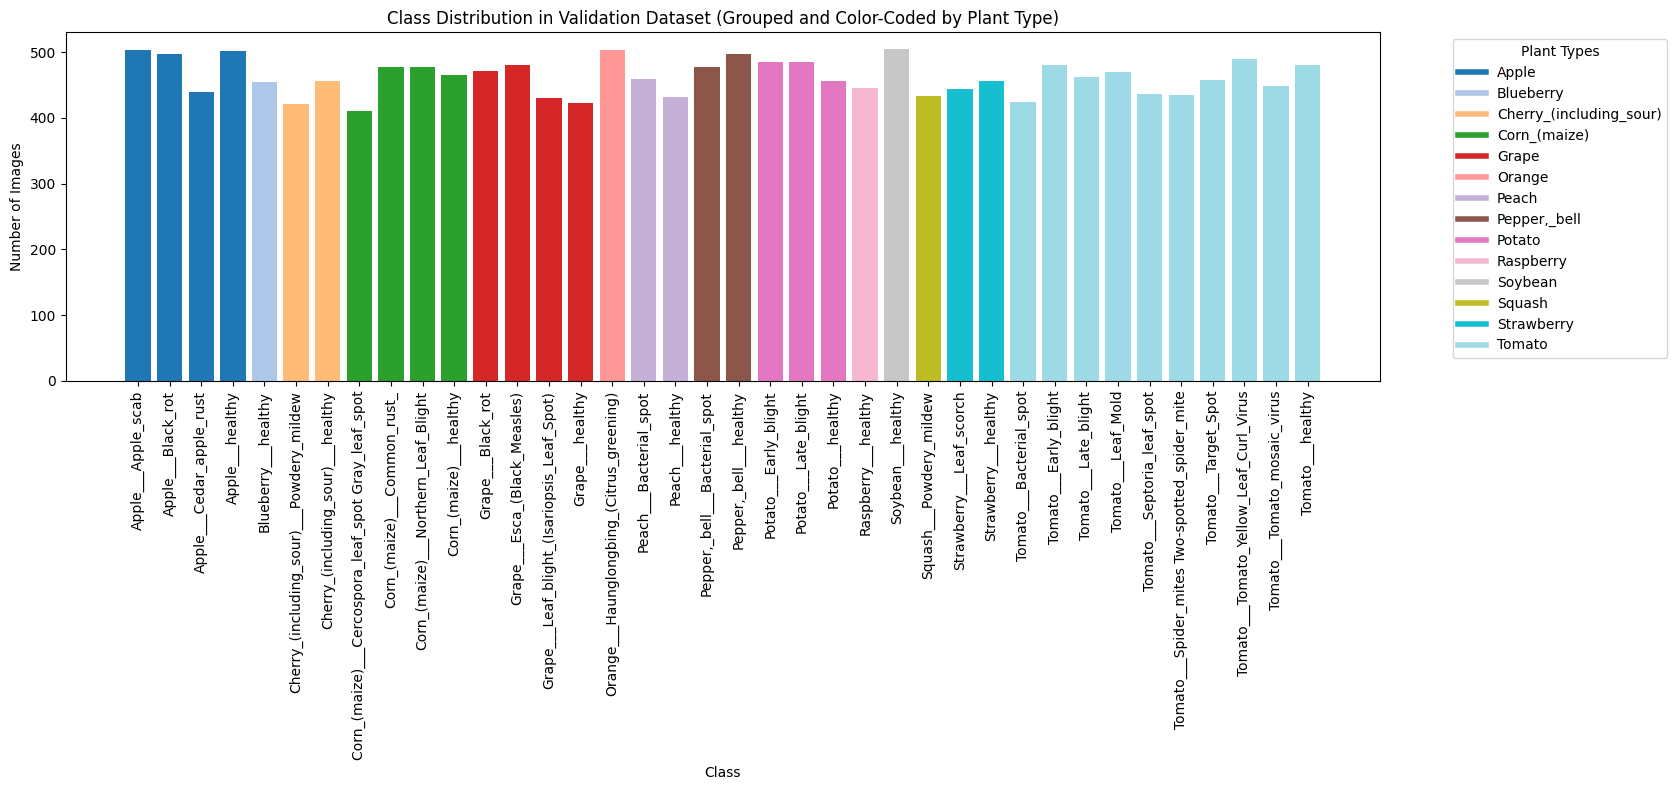

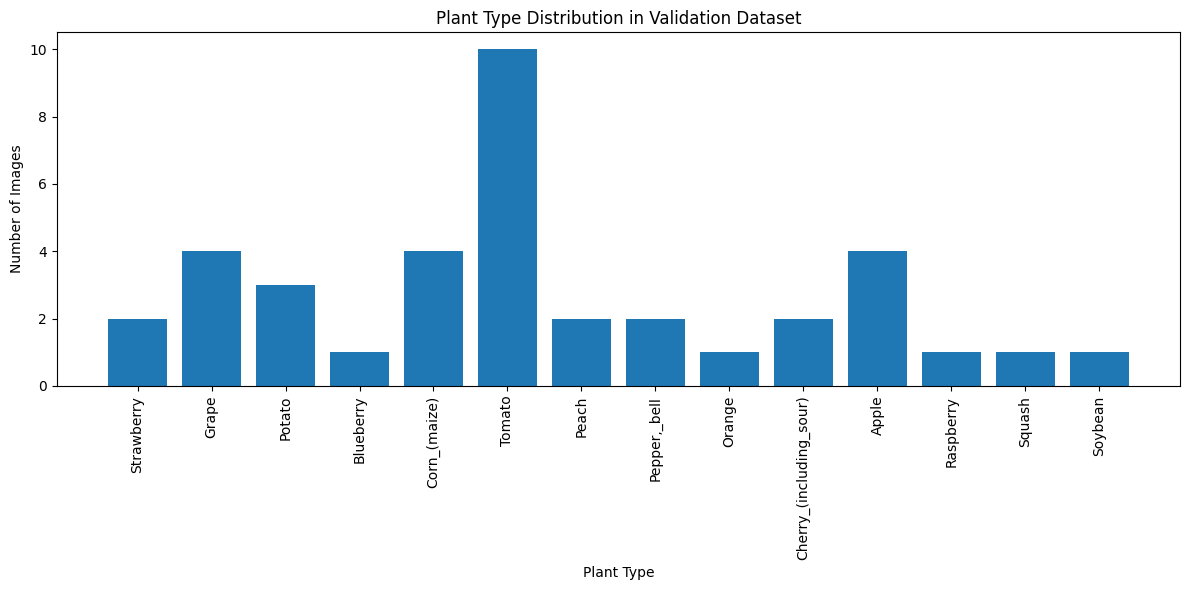

/var/folders/bt/spx_pkps3xs3hctqcx6dj9kw0000gn/T/ipykernel_14593/268566623.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Disease", bbox_to_anchor=(1.05, 1), loc='upper left')


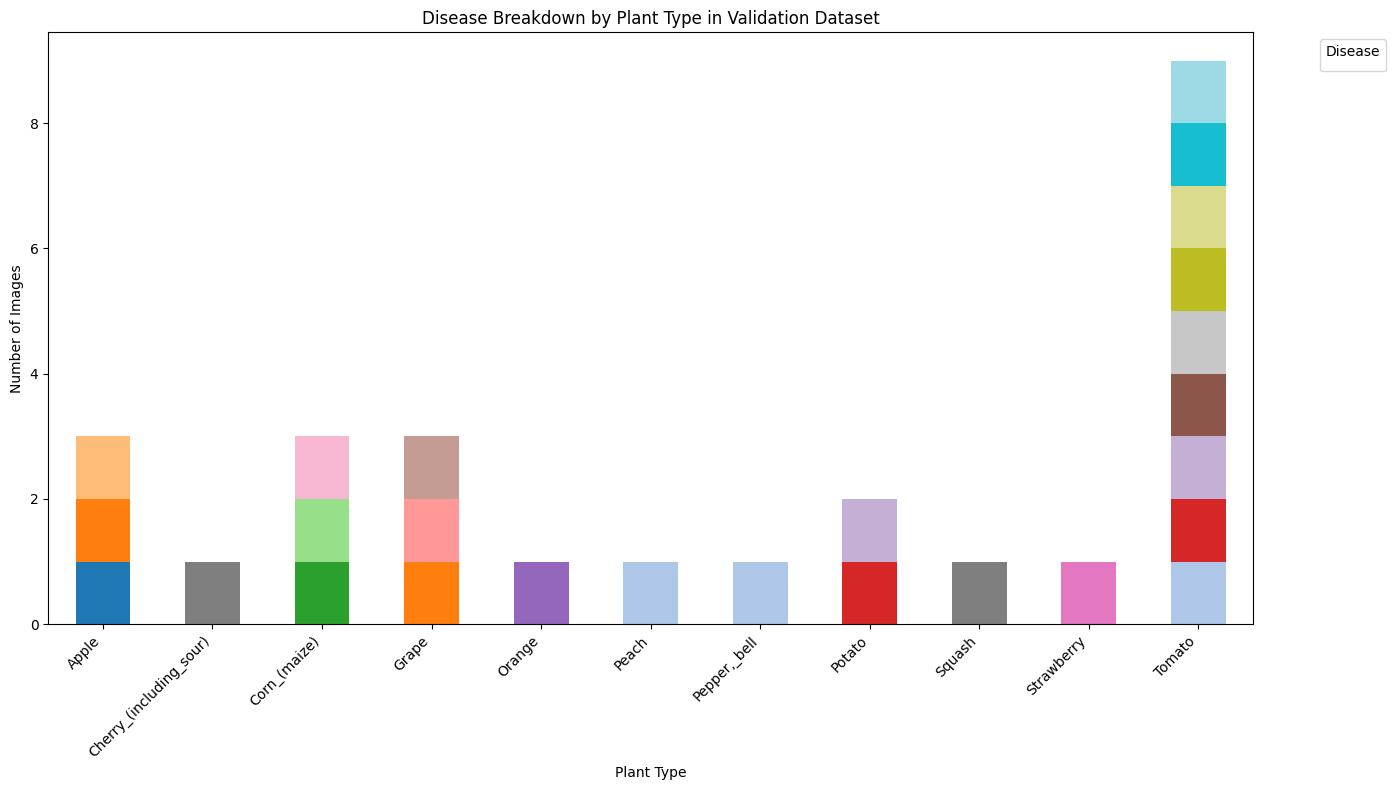

In [25]:
def analyze_dataset(input_dir):
    """Analyze dataset to retrieve basic stats and class distribution."""
    classes = []
    class_counts = {}
    plant_types = []
    diseases = []
    healthy_count = 0
    diseased_count = 0

    for cls in os.listdir(input_dir):
        cls_path = os.path.join(input_dir, cls)
        if not os.path.isdir(cls_path):  # Skip non-directory files
            continue
        classes.append(cls)
        class_counts[cls] = len(os.listdir(cls_path))

        # Split class name into plant type and disease
        if "__" in cls:
            plant, condition = cls.split("__")
            plant = plant.strip()
            condition = condition.strip()

            plant_types.append(plant)
            if "healthy" in condition.lower():  # Check for "healthy" anywhere in the condition
                healthy_count += class_counts[cls]
            else:
                diseases.append((plant, condition))
                diseased_count += class_counts[cls]

    return classes, class_counts, plant_types, diseases, healthy_count, diseased_count

def analyze_diseases_per_plant(diseases, dataset_name):
    """Analyze and visualize the breakdown of diseases per plant type."""
    # Create a dataframe for easier analysis
    disease_df = pd.DataFrame(diseases, columns=["Plant", "Disease"])
    disease_counts = disease_df.groupby(["Plant", "Disease"]).size().reset_index(name="Count")

    # Plot diseases for each plant
    for plant in disease_df["Plant"].unique():
        plant_data = disease_counts[disease_counts["Plant"] == plant]
        plt.figure(figsize=(12, 6))
        plt.bar(plant_data["Disease"], plant_data["Count"])
        plt.title(f"Disease Breakdown for {plant} in {dataset_name} Dataset")
        plt.xticks(rotation=90)
        plt.xlabel("Disease")
        plt.ylabel("Number of Images")
        plt.tight_layout()
        plt.show()

    # Calculate and display percentages for each disease
    disease_percentages = disease_df["Disease"].value_counts(normalize=True) * 100
    print(f"\nOverall Disease Percentages in {dataset_name} Dataset:")
    print(disease_percentages)

def plot_combined_disease_distribution(diseases, dataset_name):
    """Plot a stacked bar chart showing diseases for each plant type."""
    # Create a dataframe for easier analysis
    disease_df = pd.DataFrame(diseases, columns=["Plant", "Disease"])
    disease_counts = disease_df.groupby(["Plant", "Disease"]).size().unstack(fill_value=0)

    # Plot the stacked bar chart
    disease_counts.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
    plt.title(f"Disease Breakdown by Plant Type in {dataset_name} Dataset")
    plt.xlabel("Plant Type")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Disease", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_class_distribution_with_colors(class_counts, dataset_name):
    """Plot the class distribution with bars color-coded by plant type and grouped alphabetically."""
    # Extract plant types from class names
    plant_types = [cls.split("__")[0].strip() for cls in class_counts.keys()]
    unique_plant_types = sorted(set(plant_types))

    # Assign a unique color to each plant type
    cmap = cm.get_cmap('tab20', len(unique_plant_types))
    plant_colors = {plant: mcolors.to_hex(cmap(i)) for i, plant in enumerate(unique_plant_types)}

    # Combine class counts with plant types for sorting
    class_data = [(cls, count, cls.split("__")[0].strip()) for cls, count in class_counts.items()]
    sorted_class_data = sorted(class_data, key=lambda x: (x[2], x[0]))  # Sort by plant type, then class name

    # Extract sorted data
    sorted_classes = [cls for cls, _, _ in sorted_class_data]
    sorted_counts = [count for _, count, _ in sorted_class_data]
    sorted_colors = [plant_colors[plant] for _, _, plant in sorted_class_data]

    # Plot the bar chart
    plt.figure(figsize=(14, 8))
    plt.bar(sorted_classes, sorted_counts, color=sorted_colors)
    plt.xticks(rotation=90)
    plt.title(f"Class Distribution in {dataset_name} Dataset (Grouped and Color-Coded by Plant Type)")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.tight_layout()

    # Add a legend for plant types
    patches = [plt.Line2D([0], [0], color=color, lw=4) for color in plant_colors.values()]
    plt.legend(patches, unique_plant_types, title="Plant Types", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

def perform_eda():
    """Perform Exploratory Data Analysis on the training and validation datasets."""
    datasets = {"Train": train_path, "Validation": val_path}

    for dataset_name, dataset_path in datasets.items():
        print(f"\n{dataset_name} Dataset:")
        classes, class_counts, plant_types, diseases, healthy_count, diseased_count = analyze_dataset(dataset_path)

        # Basic stats
        print(f"Total classes: {len(classes)}")
        print(f"Sample classes: {classes[:5]}")
        print(f"Total images: {sum(class_counts.values())}")
        print(f"Number of plant types: {len(set(plant_types))}")
        print(f"Number of diseases: {len(set([disease for _, disease in diseases]))}")
        print(f"Healthy samples: {healthy_count}")
        print(f"Diseased samples: {diseased_count}")

        # Visualize class distribution with color-coded bars
        plot_class_distribution_with_colors(class_counts, dataset_name)

        # Visualize plant type distribution
        plot_plant_type_distribution(plant_types, dataset_name)

        # Combined disease distribution
        plot_combined_disease_distribution(diseases, dataset_name)
        
        
# Execution: EDA Section
print("\nPerforming EDA...")
perform_eda()

# Preprocessing

In [26]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler

# Paths for preprocessed dataset
output_base_path = "preprocessed_dataset"
preprocessed_train_path = os.path.join(output_base_path, "train")
preprocessed_val_path = os.path.join(output_base_path, "valid")
preprocessed_test_path = os.path.join(output_base_path, "test")

# Target image size
target_size = (224, 224)

# Toggle-able Features
CONFIG = {
    "convert_grayscale": False,         # Convert images to grayscale
    "apply_gaussian_blur": False,       # Apply Gaussian blur
    "apply_edge_detection": False,      # Apply edge detection
    "histogram_equalization": False,    # Apply histogram equalization
    "data_augmentation": True,          # Apply data augmentation
    "oversampling": False,              # Apply oversampling to balance classes
    "color_normalization": True,        # Normalize colors
    "compress_images": False,           # Compress images to save storage
    "clean_data": True                  # Remove corrupted images
}

### Preprocessing Functions ###

def preprocess_images(input_dir, output_dir, config, target_size=(224, 224), augment=False):
    """Preprocess images with toggle-able features."""
    os.makedirs(output_dir, exist_ok=True)

    datagen = None
    if augment and config["data_augmentation"]:
        datagen = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            brightness_range=[0.8, 1.2],
            fill_mode='nearest'
        )

    for cls in os.listdir(input_dir):
        cls_path = os.path.join(input_dir, cls)
        if not os.path.isdir(cls_path):
            log(f"Skipping non-directory: {cls_path}")
            continue
        output_cls_path = os.path.join(output_dir, cls)
        os.makedirs(output_cls_path, exist_ok=True)

        for img_file in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_file)
            output_img_path = os.path.join(output_cls_path, img_file)
            try:
                # Read image
                img = cv2.imread(img_path)
                if img is None:
                    if config["clean_data"]:
                        log(f"Removing corrupted image: {img_path}")
                    continue  # Skip corrupted images

                # Preprocessing steps
                img = cv2.resize(img, target_size)
                if config["convert_grayscale"]:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                if config["apply_gaussian_blur"]:
                    img = cv2.GaussianBlur(img, (5, 5), 0)
                if config["apply_edge_detection"]:
                    img = cv2.Canny(img, 100, 200)
                if config["histogram_equalization"]:
                    if len(img.shape) == 2:
                        img = cv2.equalizeHist(img)
                    else:
                        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
                        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
                        img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
                if config["color_normalization"]:
                    img = img / 255.0

                # Save augmented image
                if augment and datagen:
                    img = np.expand_dims(img, axis=0)
                    for batch in datagen.flow(img, batch_size=1):
                        aug_img = batch[0]
                        cv2.imwrite(output_img_path.replace('.jpg', '_aug.jpg'), (aug_img * 255).astype('uint8'))
                        break
                else:
                    cv2.imwrite(output_img_path, (img * 255).astype('uint8') if img.max() <= 1 else img)

            except Exception as e:
                log(f"Error processing {img_path}: {e}")


def balance_classes(input_dir, output_dir):
    """Oversample classes to balance datasets."""
    # Analyze dataset
    classes, class_counts, plant_types, diseases, healthy_count, diseased_count = analyze_dataset(input_dir)

    # Prepare data for oversampling
    samples = []
    labels = []
    for cls in classes:
        cls_path = os.path.join(input_dir, cls)
        for img_file in os.listdir(cls_path):
            samples.append(os.path.join(cls_path, img_file))
            labels.append(cls)

    # Use RandomOverSampler to balance classes
    ros = RandomOverSampler()
    balanced_samples, balanced_labels = ros.fit_resample(np.array(samples).reshape(-1, 1), labels)

    print(f"Class distribution after balancing: {Counter(balanced_labels)}")

    # Save oversampled data to the output directory
    for img_path, label in zip(balanced_samples.flatten(), balanced_labels):
        output_cls_path = os.path.join(output_dir, label)
        os.makedirs(output_cls_path, exist_ok=True)
        img_name = os.path.basename(img_path)
        cv2.imwrite(os.path.join(output_cls_path, img_name), cv2.imread(img_path))

### Execution: Preprocessing Section ###

print("\nPreprocessing datasets...")
print("Processing training set with augmentation...")
preprocess_images(train_path, preprocessed_train_path, CONFIG, target_size=target_size, augment=True)
print("Processing validation set without augmentation...")
preprocess_images(val_path, preprocessed_val_path, CONFIG, target_size=target_size, augment=False)
print("Processing test set without augmentation...")
preprocess_images(test_path, preprocessed_test_path, CONFIG, target_size=target_size, augment=False)

if CONFIG["oversampling"]:
    print("\nBalancing classes in training set...")
    balance_classes(train_path, preprocessed_train_path)

print("\nPreprocessing completed!")


Preprocessing datasets...
Processing training set with augmentation...
Processing validation set without augmentation...
Processing test set without augmentation...

Preprocessing completed!
